In [1]:
# # #5/19 테스트
# from google.colab import drive
# drive.mount('/content/drive')
import os
# os.chdir('/content/drive/MyDrive/Colab Notebooks/swishnet')
# import sys
# sys.path.append(os.getcwd())
# !pip install import-ipynb

In [2]:
times = 0

In [3]:
import torch
from torch.utils.data import DataLoader
import import_ipynb
from dataset import train_data,eval_data
from model import swishnet

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [ ]:

batch_size = 512
epochs = 500

In [6]:
model = swishnet(sample_rate=16000).to(device)
training_data = train_data()
evel_data = eval_data()
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(evel_data, batch_size=batch_size, shuffle=True)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

In [ ]:
# #load------------------------------------------------------------------------
# optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)
# epoch = 410
# times = 1
# model = swishnet(sample_rate=16000).to(device)
# model.load_state_dict(torch.load(f'swishnet_times_{times}_epoch_{epoch}.pth'))

In [8]:
def one_epoch_loop(train_dataloader, test_dataloader, model, loss_fn, optimizer, device,epoch_times):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for batch_idx, (X, y) in enumerate(train_dataloader):
        X = X.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        pred = model(X)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X.size(0)
        preds = pred.argmax(dim=1)
        train_correct += (preds == y).sum().item()
        train_total += y.size(0)

        # if batch_idx % 10 == 0:
        #     print(f"[Batch {batch_idx}] Train Loss: {loss.item():.6f}")

    train_acc = train_correct / train_total
    train_loss /= train_total

    model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for X, y in test_dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            loss = loss_fn(pred, y)

            test_loss += loss.item() * X.size(0)
            probs = torch.softmax(pred, dim=1)

            preds = probs.argmax(dim=1)# 🔸예측 클래스 index
            test_correct += (preds == y).sum().item()
            test_total += y.size(0)

    test_loss /= test_total
    test_acc = test_correct / test_total
    print(f"Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.6f}, Test Acc: {test_acc:.6f}, Train Acc: {train_acc:.6f}")
    return train_loss, test_loss, test_acc, train_acc


In [ ]:
train_loss_list = []
test_loss_list = []
test_acc_list = []
train_acc_list = []
ten_times_acc = []
for t in range(epochs):
    print(f"Epoch {t}-------------------------------")

    train_loss, test_loss, test_acc, train_acc = one_epoch_loop(train_dataloader,test_dataloader, model, loss_fn, optimizer,device,epoch_times=t)
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    if t%10==0:
        torch.save(model.state_dict(), f'swishnet_times_{times}_epoch_{t}.pth')
        ten_times_acc.append(test_acc)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)

Epoch 0-------------------------------
Train Loss: 1.237209, Test Loss: 0.972236, Test Acc: 0.625313, Train Acc: 0.491646
Epoch 1-------------------------------
Train Loss: 0.851075, Test Loss: 0.699297, Test Acc: 0.716165, Train Acc: 0.671749
Epoch 2-------------------------------
Train Loss: 0.679502, Test Loss: 0.613388, Test Acc: 0.760025, Train Acc: 0.721596
Epoch 3-------------------------------
Train Loss: 0.589851, Test Loss: 0.514396, Test Acc: 0.827694, Train Acc: 0.789056
Epoch 4-------------------------------
Train Loss: 0.480764, Test Loss: 0.425969, Test Acc: 0.857143, Train Acc: 0.841479
Epoch 5-------------------------------
Train Loss: 0.407206, Test Loss: 0.412858, Test Acc: 0.863409, Train Acc: 0.865706
Epoch 6-------------------------------
Train Loss: 0.361880, Test Loss: 0.348135, Test Acc: 0.889098, Train Acc: 0.879003
Epoch 7-------------------------------
Train Loss: 0.319506, Test Loss: 0.329011, Test Acc: 0.893484, Train Acc: 0.896617
Epoch 8-----------------

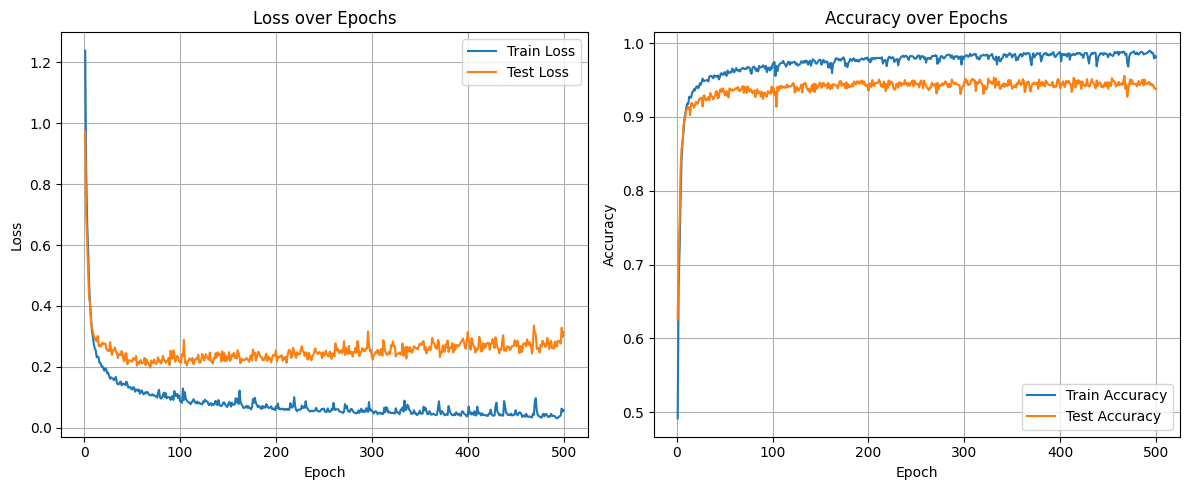

In [10]:
import matplotlib.pyplot as plt

epochs_range = range(1, len(train_loss_list) + 1)

plt.figure(figsize=(12, 5))

# 🔹 Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss_list, label='Train Loss')
plt.plot(epochs_range, test_loss_list, label='Test Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# 🔹 Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc_list, label='Train Accuracy')
plt.plot(epochs_range, test_acc_list, label='Test Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("training_results.png", dpi=300)  # 해상도 설정
plt.show()


In [17]:
best_test_acc = max(test_acc_list)
best_test_epoch = test_acc_list.index(best_test_acc)

best_ten_time_acc = max(ten_times_acc)
best_ten_time_epoch = ten_times_acc.index(best_ten_time_acc)

best_train_acc = max(train_acc_list)
best_train_epoch = train_acc_list.index(best_train_acc)

print(f"📈 Best Test Acc: {best_test_acc:.4f} at Epoch {best_test_epoch}")
print(f"📈 Best ten time Acc: {best_ten_time_acc:.4f} at Epoch {best_ten_time_epoch}")
print(f"🏋️‍♂️ Best Train Acc: {best_train_acc:.4f} at Epoch {best_train_epoch}")

📈 Best Test Acc: 0.9555 at Epoch 466
📈 Best ten time Acc: 0.9530 at Epoch 33
🏋️‍♂️ Best Train Acc: 0.9896 at Epoch 492


In [16]:
print(len(ten_times_acc))

50


In [12]:
import IPython
IPython.display.Audio(url="https://www.soundjay.com/button/beep-07.wav", autoplay=True)